# Задание 3. Кластеризация

Данные были взяты [отсюда](https://www.kaggle.com/artimous/complete-fifa-2017-player-dataset-global)

In [3]:
# импортируем нужные библиотеки
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns

# настраиваем изображение графиков
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import matplotlib.pyplot as plt

In [174]:
from scipy.cluster.hierarchy import *
from sklearn import decomposition
from sklearn.preprocessing import scale, minmax_scale
from tqdm import tqdm_notebook

In [5]:
df = pd.read_csv('FullData.csv')

In [6]:
df.head(10)

,Name,Nationality,National_Position,National_Kit,Club,Club_Position,Club_Kit,Club_Joining,Contract_Expiry,Rating,...,Long_Shots,Curve,Freekick_Accuracy,Penalties,Volleys,GK_Positioning,GK_Diving,GK_Kicking,GK_Handling,GK_Reflexes
0,Cristiano Ronaldo,Portugal,LS,7.0,Real Madrid,LW,7.0,07/01/2009,2021.0,94,...,90,81,76,85,88,14,7,15,11,11
1,Lionel Messi,Argentina,RW,10.0,FC Barcelona,RW,10.0,07/01/2004,2018.0,93,...,88,89,90,74,85,14,6,15,11,8
2,Neymar,Brazil,LW,10.0,FC Barcelona,LW,11.0,07/01/2013,2021.0,92,...,77,79,84,81,83,15,9,15,9,11
3,Luis Suárez,Uruguay,LS,9.0,FC Barcelona,ST,9.0,07/11/2014,2021.0,92,...,86,86,84,85,88,33,27,31,25,37
4,Manuel Neuer,Germany,GK,1.0,FC Bayern,GK,1.0,07/01/2011,2021.0,92,...,16,14,11,47,11,91,89,95,90,89
5,De Gea,Spain,GK,1.0,Manchester Utd,GK,1.0,07/01/2011,2019.0,90,...,12,21,19,40,13,86,88,87,85,90
6,Robert Lewandowski,Poland,LS,9.0,FC Bayern,ST,9.0,07/01/2014,2021.0,90,...,82,77,76,81,86,8,15,12,6,10
7,Gareth Bale,Wales,RS,11.0,Real Madrid,RW,11.0,09/02/2013,2022.0,90,...,90,86,85,76,76,5,15,11,15,6
8,Zlatan Ibrahimović,Sweden,NaN,NaN,Manchester Utd,ST,9.0,07/01/2016,2017.0,90,...,88,82,82,91,93,9,13,10,15,12
9,Thibaut Courtois,Belgium,GK,1.0,Chelsea,GK,13.0,07/26/2011,2019.0,89,...,17,19,11,27,12,86,84,69,91,89


В данном датасете прдеставлены данные о футболистах в игре __название игры__


### Предобработка данных

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17588 entries, 0 to 17587
Data columns (total 53 columns):
Name                  17588 non-null object
Nationality           17588 non-null object
National_Position     1075 non-null object
National_Kit          1075 non-null float64
Club                  17588 non-null object
Club_Position         17587 non-null object
Club_Kit              17587 non-null float64
Club_Joining          17587 non-null object
Contract_Expiry       17587 non-null float64
Rating                17588 non-null int64
Height                17588 non-null object
Weight                17588 non-null object
Preffered_Foot        17588 non-null object
Birth_Date            17588 non-null object
Age                   17588 non-null int64
Preffered_Position    17588 non-null object
Work_Rate             17588 non-null object
Weak_foot             17588 non-null int64
Skill_Moves           17588 non-null int64
Ball_Control          17588 non-null int64
Dribbling      

* Для начала преобразуем вес и рост в числовые признак

In [8]:
df['Weight'] = df['Weight'].apply(lambda v: int(v[:3]))

In [9]:
df['Height'] = df['Height'].apply(lambda v: int(v[:4]))

* Будем работать только с русскими игроками

In [10]:
df_rus = df[df.Nationality == 'Russia']

#### Позиции игроков

В датасате используется аббривеатура позиции игрока (ST, RW, GK, и т.д.). Нам будет интересно делить только на :
- Нападающий
- Полузащитник
- Защитник
- Вратарь

<img src='position.jpg' >

Делать это будем таким образом:
* Возьмем Preffered_Position
* Если Preffered_Position несколько, возьмем только первую
* Классифицируем с помощью рисунка выше
* Добавим признак Field в наш датасет


In [22]:
df_rus['Preffered_Position'] = df_rus['Preffered_Position'].apply(lambda v: v.split('/')[0])

/home/mikhail/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
defense = ['RWB', 'RB', 'CB', 'LB', 'LWB', 'RCB', 'LCB']
midfield = ['RM', 'CM', 'LM', 'CAM', 'CDM']
forward = ['RW', 'LW', 'CF', 'ST']
keeper = ['GK']

field = list(df_rus.Preffered_Position)
for i in range(len(field)):
    if field[i] in defense:
        field[i] = 'defense'
    elif field[i] in midfield:
        field[i] = 'midfield'
    elif field[i] in forward:
        field[i] = 'forward'
    elif field[i] in keeper:
        field[i] = 'keeper'
    else:
        field[i] = 0

In [13]:
df_rus['Field'] = field

/home/mikhail/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


 Проводить анализ будем только по количественным признакам

In [14]:
feat = ['Ball_Control', 'Dribbling', 'Marking', 'Sliding_Tackle',
       'Standing_Tackle', 'Aggression', 'Reactions', 'Attacking_Position',
       'Interceptions', 'Vision', 'Composure', 'Crossing', 'Short_Pass',
       'Long_Pass', 'Acceleration', 'Speed', 'Stamina', 'Strength', 'Balance',
       'Agility', 'Jumping', 'Heading', 'Shot_Power', 'Finishing',
       'Long_Shots', 'Curve', 'Freekick_Accuracy', 'Penalties', 'Volleys',
       'GK_Positioning', 'GK_Diving', 'GK_Kicking', 'GK_Handling',
       'GK_Reflexes']

In [358]:
X = df_rus[feat]    # признаки
y = df_rus['Field'] # их метки

In [171]:
X.describe()

,Ball_Control,Dribbling,Marking,Sliding_Tackle,Standing_Tackle,Aggression,Reactions,Attacking_Position,Interceptions,Vision,...,Long_Shots,Curve,Freekick_Accuracy,Penalties,Volleys,GK_Positioning,GK_Diving,GK_Kicking,GK_Handling,GK_Reflexes
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,...,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,55.067961,53.119741,45.414239,46.967638,47.258900,54.058252,62.077670,47.365696,45.983819,52.132686,...,46.763754,44.647249,43.090615,49.381877,42.944984,19.673139,19.915858,19.666667,19.197411,20.443366
std,18.740848,20.675804,21.912976,22.360075,22.633105,17.055196,8.595555,19.914890,20.824165,15.305287,...,20.165368,17.749753,17.482037,16.910089,17.605532,20.831886,20.917573,19.905023,19.880729,22.191921
min,11.000000,5.000000,5.000000,10.000000,9.000000,17.000000,33.000000,4.000000,6.000000,14.000000,...,5.000000,9.000000,9.000000,10.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000
25%,47.000000,45.000000,23.000000,23.000000,23.000000,39.000000,56.000000,30.000000,25.000000,45.000000,...,30.000000,33.000000,32.000000,42.000000,31.000000,8.000000,9.000000,9.000000,8.000000,9.000000
50%,61.000000,60.000000,50.000000,54.000000,54.000000,59.000000,62.000000,54.000000,50.000000,54.000000,...,52.000000,46.000000,45.000000,53.000000,46.000000,12.000000,12.000000,12.000000,12.000000,12.000000
75%,68.000000,69.000000,65.000000,67.000000,67.000000,66.000000,69.000000,62.000000,64.000000,63.000000,...,63.000000,58.000000,55.000000,61.000000,55.000000,15.000000,15.000000,15.000000,15.000000,15.000000
max,82.000000,82.000000,85.000000,84.000000,83.000000,87.000000,80.000000,83.000000,79.000000,82.000000,...,77.000000,90.000000,87.000000,85.000000,79.000000,82.000000,82.000000,78.000000,79.000000,84.000000


Нормируем признаки, так как они изменяются ~ от 0 до 90,

In [361]:
X_scale = pd.DataFrame(minmax_scale(X), columns=X.columns, index=X.index)

In [240]:
X_scale.describe()

,Ball_Control,Dribbling,Marking,Sliding_Tackle,Standing_Tackle,Aggression,Reactions,Attacking_Position,Interceptions,Vision,...,Long_Shots,Curve,Freekick_Accuracy,Penalties,Volleys,GK_Positioning,GK_Diving,GK_Kicking,GK_Handling,GK_Reflexes
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,...,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,0.620676,0.624932,0.505178,0.499563,0.517012,0.529404,0.618674,0.548933,0.547724,0.560775,...,0.580052,0.440089,0.437059,0.525092,0.506096,0.190560,0.193712,0.200913,0.191857,0.195486
std,0.263956,0.268517,0.273912,0.302163,0.305853,0.243646,0.182884,0.252087,0.285263,0.225078,...,0.280075,0.219133,0.224129,0.225468,0.241172,0.270544,0.271657,0.272672,0.268658,0.280910
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.507042,0.519481,0.225000,0.175676,0.189189,0.314286,0.489362,0.329114,0.260274,0.455882,...,0.347222,0.296296,0.294872,0.426667,0.342466,0.038961,0.051948,0.054795,0.040541,0.050633
50%,0.704225,0.714286,0.562500,0.594595,0.608108,0.600000,0.617021,0.632911,0.602740,0.588235,...,0.652778,0.456790,0.461538,0.573333,0.547945,0.090909,0.090909,0.095890,0.094595,0.088608
75%,0.802817,0.831169,0.750000,0.770270,0.783784,0.700000,0.765957,0.734177,0.794521,0.720588,...,0.805556,0.604938,0.589744,0.680000,0.671233,0.129870,0.129870,0.136986,0.135135,0.126582
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Кластеризация

### 1. K-means

Для начала разобьем на 4 класса

In [131]:
from sklearn.cluster import KMeans

Для воспроизводимости будем фиксировать random_state=17

In [207]:
kmeans = KMeans(n_clusters=4, n_init=100, random_state=17, n_jobs=-1)
kmeans.fit(X_scale)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=100, n_jobs=-1, precompute_distances='auto',
    random_state=17, tol=0.0001, verbose=0)

Посмотрим на соответсвия между метками класетров и исходными метками и на то, как KMeans путает позиии игроков

In [208]:
cluster_labels = kmeans.labels_
for i in range(len(cluster_labels)):
    cluster_labels[i] == y.unique()[cluster_labels[i]]
    
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.columns = ['cluster' + str(i + 1) for i in range(4)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,все
Field,,,,,
defense,0,56,37,1,94
forward,0,0,3,42,45
keeper,51,0,0,0,51
midfield,0,16,57,46,119
All,51,72,97,89,309


Видим, что лучше всего кластеризовались вратари и нападающие. А вот полузащитники рассыпались по всем трем классам, что не удивительно в футболе

Посмотрим какое количество кластеров оптимально взять (глядя на таблицу выше, можно предположить, что это будет 2 или 3)

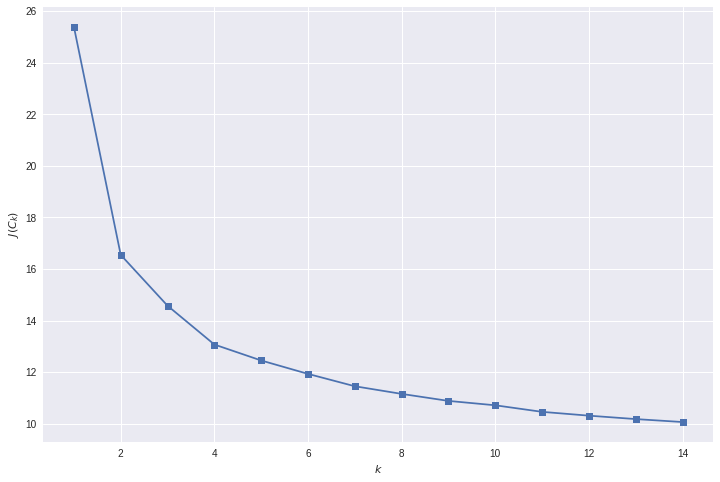

In [177]:
inertia = []
for k in tqdm_notebook(range(1, 15)):
    kmeans = KMeans(n_clusters=k, random_state=17).fit(X_scale)
    inertia.append(np.sqrt(kmeans.inertia_))
plt.plot(range(1, 15), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Впрочем, 4 не такой уж и плохой вариант

Так как мы имеем реальные метки, хочется проверить качество нашей кластеризации с помощью какой-нибудь метрики. Для простоты пусть это будет [ARI]('https://en.wikipedia.org/wiki/Rand_index').

Если очень коротко, то ARI принимает значение в интервле [-1, 1]. Отрицательные значения соответствуют "независимым" разбиениям на кластеры, значения, близкие к нулю, - случайным разбиениям, и положительные значения говорят о том, что два разбиения схожи (совпадают при ARI=1).

In [205]:
from sklearn.metrics import adjusted_rand_score

In [209]:
adjusted_rand_score(y, cluster_labels)

0.37341522023864454

### 2. PCA (Principal Component Analysis)

Он же метод главных компонент.

In [179]:
from sklearn.decomposition import PCA

#### 2.1 n_components=2

Для начала понизим размерность до двух, и посмотрим как наши игроки разделяются 'на глаз'

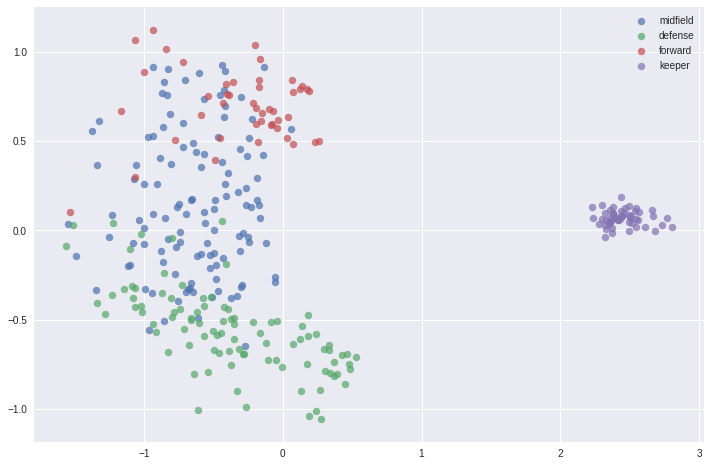

In [196]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scale)
X_new = np.c_[X_reduced, y]
for pos in y.unique():
    x = X_new[X_new[:,2] == pos]
    plt.scatter(x[:, 0], x[:, 1], alpha=0.7, s=50,
             cmap=plt.cm.get_cmap('nipy_spectral', 10), );
    plt.legend(y.unique())

Отчетливо видно как отделились голкиперы. Также можно заметить как разделились полевые футболисты. Например, если убрать полузащтников, то будет 3 линейно отделимых кластера.

#### 2.2 PCA + KMeans

Теперь снизим размерность и кластеризуем KMeans'ом. 

Количество главных компонент будем выбирать столько, сколько оставляет как минимум 90% дисперсии исходных данных.

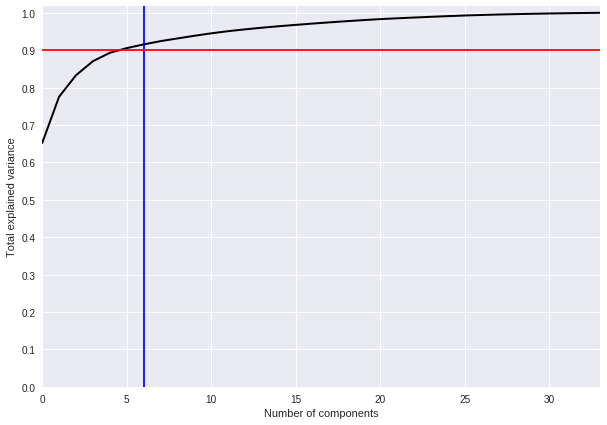

In [197]:
pca = PCA().fit(X_scale)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 33)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(6, c='b')
plt.axhline(0.9, c='r')
plt.show();

Итого 6 компонент. Мы понизим нашего пространство в 5 раз, не теряя особо много информации при этом.

In [223]:
pca = PCA(n_components=6, random_state=17)
X_reduced = pca.fit_transform(X_scale)

In [224]:
kmeans = KMeans(n_clusters=4, n_init=100, random_state=17, n_jobs=-1)
kmeans.fit(X_reduced)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=100, n_jobs=-1, precompute_distances='auto',
    random_state=17, tol=0.0001, verbose=0)

Опять посмотрим на таблицу разбиения по кластерам

In [225]:
cluster_labels = kmeans.labels_
for i in range(len(cluster_labels)):
    cluster_labels[i] == y.unique()[cluster_labels[i]]
    
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.columns = ['cluster' + str(i + 1) for i in range(4)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,все
Field,,,,,
defense,1,0,43,50,94
forward,42,0,3,0,45
keeper,0,51,0,0,51
midfield,49,0,60,10,119
All,92,51,106,60,309


Разбиение примерно такое же как и было на непониженных данных. Но посмторим на ARI.

In [226]:
adjusted_rand_score(y, cluster_labels)

0.37529417617284128

Качество улучшилось на на 0.002, что не может не радовать (warning:sarcasm)

### 3.T-SNE

T-SNE делать то же самое, что и PCA, только использует для этого нейросети. Сследовательно, время на обучение больше, зато результат, как правило лучше.

In [229]:
from sklearn.manifold import TSNE


In [232]:
%%time
tsne = TSNE(n_components=2, random_state=17)
X_tsne = tsne.fit_transform(X_scale)


CPU times: user 6.19 s, sys: 352 ms, total: 6.54 s
Wall time: 6.55 s


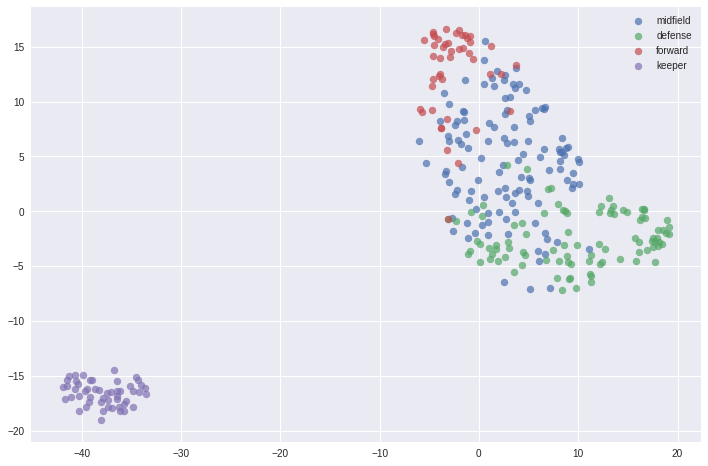

In [233]:
X_new = np.c_[X_tsne, y]

for pos in y.unique():
    x = X_new[X_new[:,2] == pos]
    plt.scatter(x[:, 0], x[:, 1], alpha=0.7, s=50,
             cmap=plt.cm.get_cmap('nipy_spectral', 10), );
    plt.legend(y.unique())

Наверное, визуально T-SNE лучше, но это не точно.

### 4. Afinity Propagation

Про алгоритм [тут](https://en.wikipedia.org/wiki/Affinity_propagation)

Самое главное отличие этого алгоритма от __Kmeans__ в том, что нам не обязательно заранее определять количество классов.

In [238]:
from sklearn.cluster import AffinityPropagation

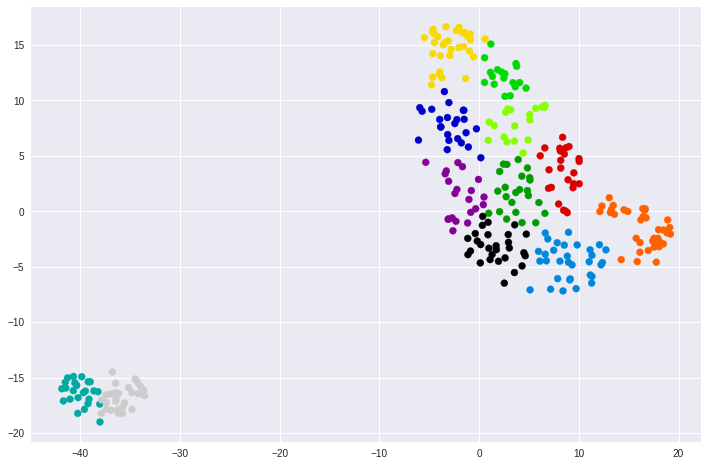

In [309]:
ap = AffinityPropagation()
tsne = TSNE(n_components=2, random_state=17)
X_tsne = tsne.fit_transform(X_scale)
ap.fit(X_tsne)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=ap.labels_,
           cmap=plt.cm.get_cmap('nipy_spectral', len(np.unique(ap.labels_))));


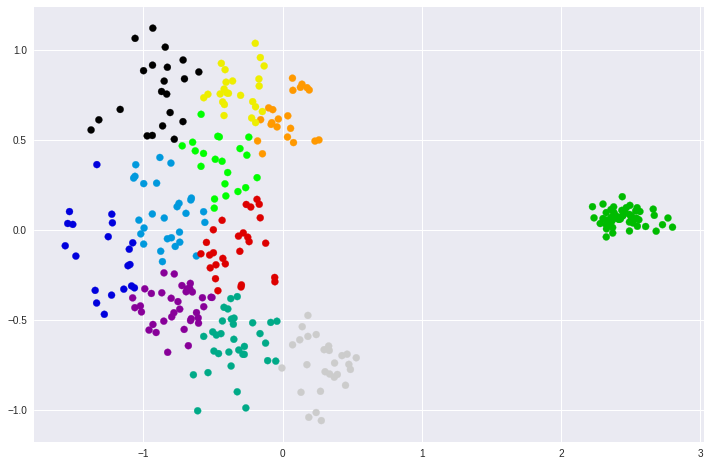

In [311]:
ap = AffinityPropagation()
pca = PCA(n_components=2, random_state=17)
X_pca= pca.fit_transform(X_scale)
ap.fit(X_pca)
plt.scatter(X_pca[:,0], X_pca[:,1], c=ap.labels_,
           cmap=plt.cm.get_cmap('nipy_spectral', len(np.unique(ap.labels_))));


Видно, что алгоритм выбрал довольно много классов. Наверное, это связано с тем, что разделение на те 4 класса, которое мы проделали в начале, слишком условное. Возможно алгоритм разделил игроков согласно их позиции (CAM, ST, RW и тп, а не нападающий, защитник и т.п.). Проверять я это не буду :(

Заметим еще одну странную вещь. В кластеризации обученной на T-SNE вратари разделись на два класса.


### 5. Иерархический кластерный анализ

In [313]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

In [421]:
distance_mat = pdist(np.array(X_scale)) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat) # linkage — реализация агломеративного алгоритма


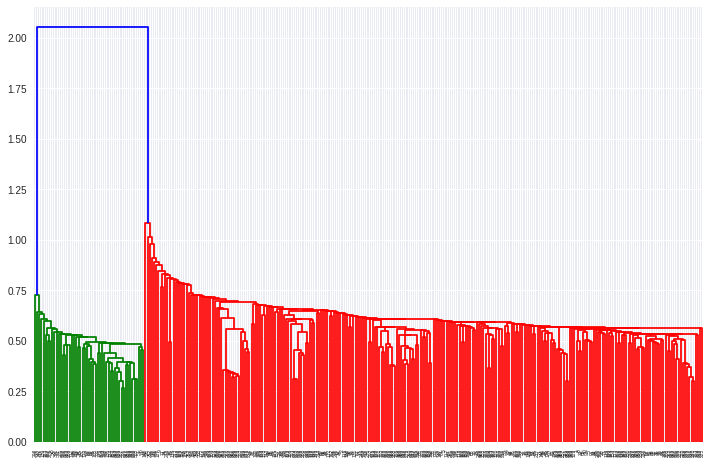

In [491]:
dn = hierarchy.dendrogram(Z)

Как видим на дендограмме, алгоритм очень хорошо различает два класса. Скорее всего это класс вратарей и класс всех остальных игроков.

Попробуем все таки разделить на три класса, поставив color_threshold=0.75 (Это значит, что цвет(класстер) будет менятся при расстоянии(ось Y) меньшем чем 0.75)

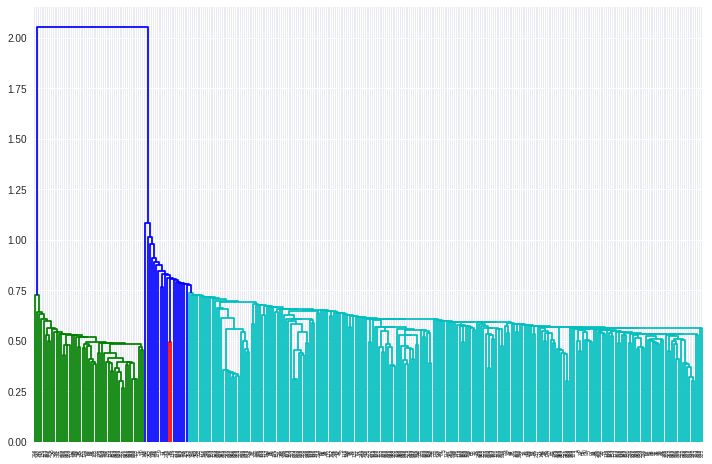

In [493]:
dn = hierarchy.dendrogram(Z, color_threshold=0.75)

Посмотрим на классы пофамильно.

In [494]:
from collections import defaultdict
clusterdict = defaultdict(list)
for ind,clust in zip(dn['leaves'],dn['color_list']):
    clusterdict[clust].append(ind)

In [534]:
clusterdict

defaultdict(list,
            {'b': [31,
              20,
              24,
              198,
              206,
              263,
              221,
              287,
              300,
              306,
              222,
              270,
              286,
              275,
              277,
              239,
              240,
              153,
              224,
              215],
             'c': [96,
              252,
              16,
              110,
              54,
              127,
              9,
              71,
              74,
              273,
              10,
              19,
              114,
              212,
              132,
              123,
              152,
              83,
              109,
              253,
              57,
              159,
              80,
              254,
              63,
              177,
              116,
              50,
              238,
              124,
              104,
              128,


Построим такую матрицу: имя, позиция, предпочитаемое амплуа и матрица с названием колонок 'g', 'b','r','c'(первая буква цветов из дендограммы). '1' значит игрок в данном кластере, 0 нет.

In [519]:
df_ier = df_rus[['Name', 'Field', 'Preffered_Position']]
df_ier['g'] = 0
df_ier['b'] = 0
df_ier['r'] = 0
df_ier['c'] = 0

/home/mikhail/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mikhail/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mikhail/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [535]:
for key in clusterdict.keys():
    for i in clusterdict[key]:
        df_ier[key].values[i] = 1

In [550]:
df_ier[df_ier.c == 1].Field.value_counts()

midfield    101
defense      92
forward      44
Name: Field, dtype: int64

In [551]:
df_ier[df_ier.g == 1].Field.value_counts()

keeper    50
Name: Field, dtype: int64

In [552]:
df_ier[df_ier.r == 1].Field.value_counts()

forward    1
Name: Field, dtype: int64

In [553]:
df_ier[df_ier.b == 1].Field.value_counts()

midfield    17
defense      2
keeper       1
Name: Field, dtype: int64

Видим, что в класс красных попал всего один нападающий. Наверное  color_threshold=0.75 надо было взять немного побольше.

А вот в голубом цвете находятся почти все полевые игроки.

In [554]:
df_ier

,Name,Field,Preffered_Position,g,b,r,c
303,Oleg Shatov,midfield,LM,0,0,0,1
333,Alan Dzagoev,midfield,CM,0,0,0,1
334,Igor Smolnikov,defense,RB,0,0,0,1
450,Mário Fernandes,defense,RB,0,0,0,1
465,Fedor Smolov,forward,ST,0,0,0,1
510,Igor Akinfeev,keeper,GK,1,0,0,0
545,Stanislav Kritsyuk,keeper,GK,1,0,0,0
565,Denis Cheryshev,midfield,LM,0,0,0,1
635,Pavel Mamaev,forward,RW,0,0,0,1
636,Artem Dzyuba,forward,ST,0,0,0,1
